In [62]:
import numpy as np
import pandas as pd
import os
from re import search
import shutil
import natsort
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import cv2

In [61]:
#!pip install opencv-python

In [12]:
DIR= r'C:\Datasets\Plant diseases\images'

In [14]:
train=pd.read_csv(r"C:\Datasets\Plant diseases\train.csv")
test=pd.read_csv(r"C:\Datasets\Plant diseases\test.csv")

In [15]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [16]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


# Preparing the Training data

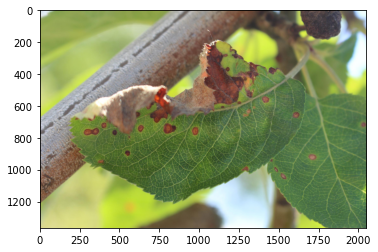

In [18]:
image1= Image.open(r'C:\Datasets\Plant diseases\images\Train_1.jpg')
plt.imshow(image1)
plt.show()

In [19]:
class_names=train.loc[:,'healthy':].columns
print(class_names)

Index(['healthy', 'multiple_diseases', 'rust', 'scab'], dtype='object')


In [22]:
number=0
train['label']=0
for i in class_names:
    train['label']=train['label']+ train[i]*number
    number= number+1

In [23]:
train

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0
...,...,...,...,...,...,...
1816,Train_1816,0,0,0,1,3
1817,Train_1817,1,0,0,0,0
1818,Train_1818,1,0,0,0,0
1819,Train_1819,0,0,1,0,2


In [24]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0


In [33]:
DIR

'C:\\Datasets\\Plant diseases\\images'

In [49]:
def get_label_img(img):
    if search("Train",img):
        img=img.split('.')[0]
        label=train.loc[train['image_id']==img]['label']
        return label

In [29]:
img ='Train_66.jpg'

In [31]:
img.split('.')[0]

'Train_66'

In [55]:
def create_train_data():
    images=natsort.natsorted(os.listdir(DIR))
    for img in tqdm(images):
        label=get_label_img(img)
        path=os.path.join(DIR,img)
        
        if search("Train", img):
            if(img.split("_")[1].split(".")[0]) and label.item()==0:
                shutil.copy(path, r'C:\Datasets\Plant diseases\images\train\healthy')
                
            elif(img.split("_")[1].split(".")[0]) and label.item()==1:
                shutil.copy(path, r'C:\Datasets\Plant diseases\images\train\multiple_diseases')
       
            elif(img.split("_")[1].split(".")[0]) and label.item()==2:
                shutil.copy(path, r'C:\Datasets\Plant diseases\images\train\rust')
                
            elif(img.split("_")[1].split(".")[0]) and label.item()==3:
                shutil.copy(path, r'C:\Datasets\Plant diseases\images\train\scab')
                
        elif search("Test", img):
                shutil.copy( path,r'C:\Datasets\Plant diseases\images\test')

In [51]:
shutil.os.mkdir(r'C:\Datasets\Plant diseases\images\train')
shutil.os.mkdir(r'C:\Datasets\Plant diseases\images\train\healthy')
shutil.os.mkdir(r'C:\Datasets\Plant diseases\images\train\multiple_diseases')
shutil.os.mkdir(r'C:\Datasets\Plant diseases\images\train\rust')
shutil.os.mkdir(r'C:\Datasets\Plant diseases\images\train\scab')

shutil.os.mkdir(r'C:\Datasets\Plant diseases\images\test')

In [56]:
train_dir=create_train_data()

100%|██████████| 3644/3644 [00:18<00:00, 196.82it/s]


# Data Preprocessing

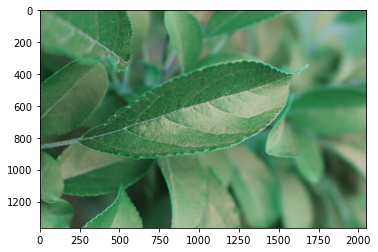

In [71]:
Train_DIR=r'C:\Datasets\Plant diseases\images\train'
Categories=['healthy','multiple_disease','rust','scab']

for j in Categories:
    path=os.path.join(Train_DIR,j)
    for img in os.listdir(path):
        old_image=cv2.imread(os.path.join(path,img),cv2.COLOR_BGR2RGB)
        plt.imshow(old_image)
        plt.show()
        break
    break
      

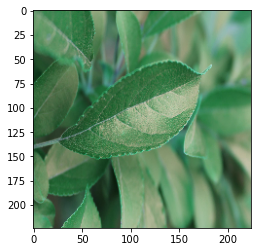

In [72]:
IMG_SIZE=224
new_image=cv2.resize(old_image,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_image)
plt.show()

# Model Preparation

In [73]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten,Conv2D,MaxPooling2D

In [77]:
datagen=ImageDataGenerator(rescale=1./255,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True,
                                validation_split=0.2)

train_datagen=datagen.flow_from_directory(r'C:\Datasets\Plant diseases\images\train',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=16,
                                         class_mode='categorical',
                                         subset='training')

val_datagen=datagen.flow_from_directory(r'C:\Datasets\Plant diseases\images\train',
                                         target_size=(IMG_SIZE,IMG_SIZE),
                                         batch_size=16,
                                         class_mode='categorical',
                                         subset='validation')


Found 1458 images belonging to 4 classes.
Found 363 images belonging to 4 classes.


In [85]:
model=Sequential()
model.add(Conv2D(64,(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(4,activation='softmax'))
          
# compile the model
model.compile(optimizer='Adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()




Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 24, 24, 128)      

In [87]:
checkpoint=ModelCheckpoint(r'C:\Datasets\Plant diseases\models\apple2.h5',
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          verbose=1)
earlystop=EarlyStopping(monitor='val_loss',
                       min_delta=0,
                       patience=10,
                       verbose=1,
                       restore_best_weights=True)

callbacks=[checkpoint,earlystop]


In [88]:
model_history=model.fit_generator(train_datagen,validation_data=val_datagen,
                                 epochs=30,
                                 steps_per_epoch=train_datagen.samples//16,
                                 validation_steps=val_datagen.samples//16,
                                 callbacks=callbacks)

Epoch 1/30
91/91 [==============================] - 96s 1s/step - loss: 1.2762 - accuracy: 0.3377 - val_loss: 1.2482 - val_accuracy: 0.3864

Epoch 00001: val_loss improved from inf to 1.24824, saving model to C:\Datasets\Plant diseases\models\apple2.h5
Epoch 2/30
91/91 [==============================] - 97s 1s/step - loss: 1.2494 - accuracy: 0.3190 - val_loss: 1.2439 - val_accuracy: 0.3381

Epoch 00002: val_loss improved from 1.24824 to 1.24392, saving model to C:\Datasets\Plant diseases\models\apple2.h5
Epoch 3/30
91/91 [==============================] - 99s 1s/step - loss: 1.2337 - accuracy: 0.3474 - val_loss: 1.1659 - val_accuracy: 0.4574

Epoch 00003: val_loss improved from 1.24392 to 1.16595, saving model to C:\Datasets\Plant diseases\models\apple2.h5
Epoch 4/30
91/91 [==============================] - 99s 1s/step - loss: 1.2063 - accuracy: 0.3953 - val_loss: 1.1196 - val_accuracy: 0.4716

Epoch 00004: val_loss improved from 1.16595 to 1.11957, saving model to C:\Datasets\Plant di

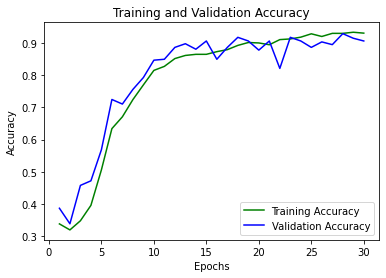

In [89]:
acc_train=model_history.history['accuracy']
acc_val=model_history.history['val_accuracy']
epochs=range(1,31)
plt.plot(epochs,acc_train,'g',label='Training Accuracy')
plt.plot(epochs,acc_val,'b',label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

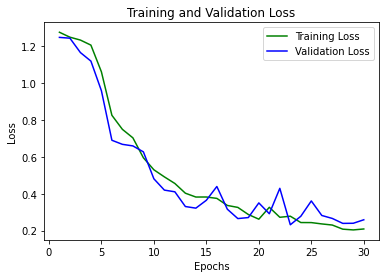

In [90]:
loss_train=model_history.history['loss']
loss_val=model_history.history['val_loss']
epochs=range(1,31)
plt.plot(epochs,loss_train,'g',label='Training Loss')
plt.plot(epochs,loss_val,'b',label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Making the Prediction on a Single Image

3


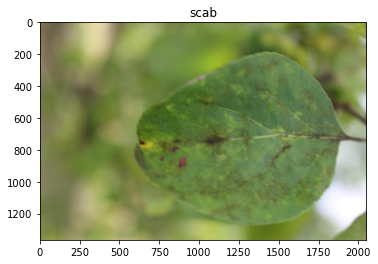

In [106]:
test_image=r'C:\Datasets\Plant diseases\images\test\Test_7.jpg'
image_result=Image.open(test_image)

from tensorflow.keras.preprocessing import image
test_image=image.load_img(test_image,target_size=(224,224))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)
print(np.argmax(result))
Categories=['healthy','multiple_diseases','rust','scab']
image_result=plt.imshow(image_result)
plt.title(Categories[np.argmax(result)])
plt.show()
